In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -*- coding: utf-8 -*-
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Softmax, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
# from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import matplotlib.pyplot as plt
import pandas as pd
#from data_pp_mmwave import *
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

import os

In [3]:
import numpy as np
import pickle

def read_from_pickle(path, time_steps = 5):
    f = open(path,'rb')
    x = pickle.load(f)
    f.close()
    keys = ['x', 'y', 'z']
    for time_segment in range(len(x)//time_steps):
        #print('time segment'+str(time_segment) + 'range' + str(range(len(x)//time_steps)))
        for t in range(time_steps):
            s = np.array([x[time_segment*time_steps+t].get(k).mean() for k in keys])
            if t == 0:
                sample = s
            else:
                sample = np.vstack((sample , s))

        sample = np.expand_dims(sample, axis=0)
        #print(sample)
        if time_segment == 0:
            data = sample
        else:
            data = np.vstack((data, sample))
    return data

In [4]:
from pandas import read_csv
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Conv1D, Flatten
import matplotlib.pyplot as plt
from keras import layers
import numpy as np
from keras.utils import to_categorical

%matplotlib inline

import os

data_dir = "/content/drive/MyDrive/Colab Notebooks/breathingdata/breathing_data.pkl"

step = 12
data  = read_from_pickle(data_dir, step)
data = data.reshape(-1,3)
data.shape


(43032, 3)

In [5]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
    
df_unscaled = pd.DataFrame(data,columns=['x','y','z']) 

df_unscaled

,x,y,z
0,-0.341283,0.616262,-0.083882
1,-0.408203,0.599981,-0.167132
2,-0.461914,0.486028,0.004432
3,-0.194901,0.683388,-0.196443
4,-0.293203,0.604609,-0.073594
...,...,...,...
43027,-0.233724,0.475477,-0.002604
43028,-0.206380,0.508626,0.026042
43029,-0.171875,0.580078,0.080078
43030,-0.174316,0.551758,0.088379


[ 0 -1 -1 ...  1  1  1]
43032
[ 0 -1 -1 ...  1  1  1]
{0, 1, 2, 3, 4, 5, -1}
['yellow', 'green', 'red', 'orange', 'purple']


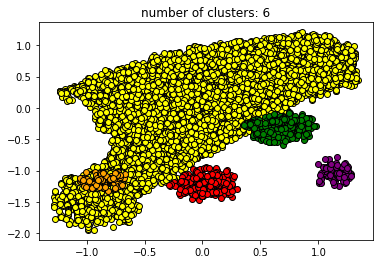

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
    
df_unscaled = pd.DataFrame(data)    
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_unscaled)
df_scaled

# cluster the data into five clusters
dbscan = DBSCAN(eps=0.163, min_samples = 60)
clusters = dbscan.fit(df_scaled)

print(clusters.labels_)

print(len(clusters.labels_))

core_samples_mask = np.zeros_like(clusters.labels_, dtype=bool)
core_samples_mask[clusters.core_sample_indices_] = True
labels = clusters.labels_
  
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  
print(labels)
  
# Plot result
import matplotlib.pyplot as plt
  
# Black removed and is used for noise instead.
unique_labels = set(labels)
print(unique_labels)
colors = ['yellow', 'green', 'red','orange','purple']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
  
    class_member_mask = (labels == k)
  
    xy = df_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                                      markeredgecolor='k', 
                                      markersize=6)
  
    xy = df_scaled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                                      markeredgecolor='k',
                                      markersize=6)
  
plt.title('number of clusters: %d' %n_clusters_)
plt.show()

In [7]:
df_clustered = pd.DataFrame(df_scaled)
df_clustered['Cluster_labels'] = clusters.labels_

df_clustered['Cluster_labels'].unique().tolist()

df_filtered = df_clustered[df_clustered['Cluster_labels'] != 3]

df_filtered.shape

df_filtered


,0,1,2,Cluster_labels
0,-0.514929,0.017731,-0.156174,0
1,-0.955484,-0.082757,-0.738435,-1
2,-1.309079,-0.786096,0.461502,-1
3,0.448743,0.432041,-0.943444,0
4,-0.198406,-0.054193,-0.084220,0
...,...,...,...,...
43027,0.193162,-0.851214,0.412290,-1
43028,0.373174,-0.646614,0.612642,-1
43029,0.600332,-0.205603,0.990580,1
43030,0.584259,-0.380400,1.048636,1


In [8]:
df_person_1 = df_clustered[df_clustered['Cluster_labels'] == -1]
df_person_2 = df_clustered[df_clustered['Cluster_labels'] == 0]

print(df_person_1.shape)
print(df_person_2.shape)

#df_scaled
df_p1 = pd.DataFrame(df_person_1)

df_p2 = pd.DataFrame(df_person_2)

df_p2

(19176, 4)
(22716, 4)


,0,1,2,Cluster_labels
0,-0.514929,0.017731,-0.156174,0
3,0.448743,0.432041,-0.943444,0
4,-0.198406,-0.054193,-0.084220,0
5,-0.549589,-0.438883,-0.314541,0
12,-0.671255,0.312126,-0.629974,0
...,...,...,...,...
42865,0.055668,-0.525783,0.447989,0
42870,-0.234008,-0.969085,0.428986,0
42883,-0.119715,-0.898764,0.307560,0
42984,0.356030,-0.253823,0.198277,0


In [9]:
import matplotlib.pyplot as plt
import numpy as np


def plot_polar_graphs(df):

  # build polar co-ordinates showing angle and velocity

  x,y = df[0], df[1]
  r = np.sqrt(x**2+y**2)
  t = np.arctan2(y,x)
  wave = np.array(r)*np.array(t)

  plt.plot(wave)
  plt.show()

  return r,t

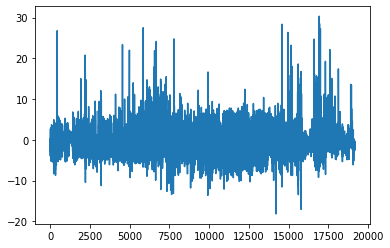

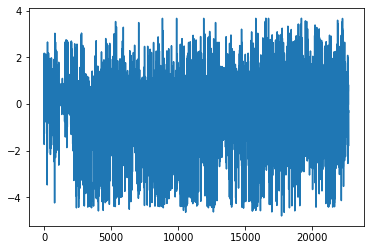

In [12]:
r_p1,t_p1 = plot_polar_graphs(df_person_1)
r_p2,t_p2 = plot_polar_graphs(df_person_2)


In [13]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

def apply_fft(n,r,t):

  # Number of sample points
  N = n
  print(N)
  # sample spacing
  T = 1.0 / 10.0
  x = np.linspace(0.0, N*T, N, endpoint=False)
  print(t.shape)
  y = np.array(r) * np.array(t)
  yf = fft(y)
  xf = fftfreq(N, T)[:N//2]
  plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
  plt.grid()
  plt.show()
  return yf,y

19176
(19176,)


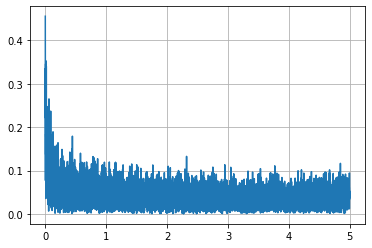

22716
(22716,)


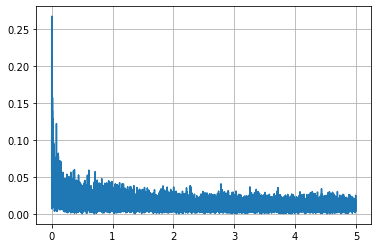

In [14]:
yf_p1,y_p1 = apply_fft(r_p1.shape[0],r_p1,t_p1)
yf_p2,y_p2 = apply_fft(r_p2.shape[0],r_p2,t_p2)

In [16]:
!pip install sensormotion
from scipy.fft import fft, fftfreq
import sensormotion as sm

def low_pass_find_breaths(yf):
  time = np.arange(yf.shape[0]) # times in milliseconds

  _ = sm.signal.fft(yf, 100, plot=True)

  #creating a low pass filter with frequency set to 10 hz

  sm.plot.plot_filter_response(10, 100, 'low', filter_order=30)
  b, a = sm.signal.build_filter(10, 100, 'low', filter_order=30)

  # applying the low pass filter

  y_f = sm.signal.filter_signal(b, a, yf)  # on signal y which is a composite signal of polar coordinates.
  peak_times, peak_values = sm.peak.find_peaks(time, y_f, peak_type='peak', min_val=0.2, min_dist=30, plot=True)

  # Gait metrics peaking finding which translates to chest motion 

  step_count = sm.gait.step_count(peak_times)
  cadence = sm.gait.cadence(time, peak_times)

  step_time, step_time_sd, step_time_cov = sm.gait.step_time(peak_times)

  # Number of steps indicate a change in breathing pattern
  print(' - Number of steps: {}'.format(step_count))
  return step_count

  Created wheel for sensormotion: filename=sensormotion-1.1.4-cp37-none-any.whl size=19675 sha256=5cbc30ad8dfa65fd30d98064d6e6d9cff5314d2d29b450fa78c73bc1442b9251
  Stored in directory: /root/.cache/pip/wheels/37/fd/45/ab09232b95205e7fbacf21d60e3472e5b53a1adeee9c1d7711
Successfully built sensormotion


In [34]:
end = 300
count = 0
breath_permin_p1 = []
breath_permin_p2 = []

step_size = 300
data_points = 18000 # 60 mins sized into 300 points per min
for i in range(0,data_points,step_size):
   end = end + 300
   p1_step_count = low_pass_find_breaths(yf_p1[i:end])
   p2_step_count = low_pass_find_breaths(yf_p2[i:end])

   for i in range(0,300,1):
       breath_permin_p2.append(p2_step_count)
       breath_permin_p1.append(p1_step_count)

   count = count+1

print(count)
#print("Average breathing rate over 36 mins is " + str(p1_step_count/2) + " (b/min) breaths per minute")

len(breath_permin_p1)
len(breath_permin_p2)

Output hidden; open in https://colab.research.google.com to view.

In [80]:
import pandas as pd

breath_p1 = np.array(breath_permin_p1)
breath_p2 = np.array(breath_permin_p2)

df_1 = pd.DataFrame(df_person_1[0:18000])
df_2 = pd.DataFrame(df_person_2[0:18000])

df_1['breaths'] = breath_p1
df_2['breaths'] = breath_p2

df_1.drop('Cluster_labels', axis =1, inplace = True)
df_2.drop('Cluster_labels', axis =1, inplace = True)

print(df_1.shape)
print(df_2.shape)

df_1

(18000, 4)
(18000, 4)


,0,1,2,breaths
1,-0.955484,-0.082757,-0.738435,15
2,-1.309079,-0.786096,0.461502,15
6,-0.829762,-0.179261,-0.453374,15
7,-0.903296,0.214194,-0.734647,15
8,-1.001406,-0.227130,-0.302279,15
...,...,...,...,...
41043,0.227450,-0.615472,0.362202,14
41044,0.990357,-0.142649,0.662730,14
41045,0.993215,-0.047549,0.729514,14
41046,-0.145431,-1.320688,0.683221,14


In [79]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [89]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# load dataset for p1
dataset_p1 = df_1.values
# split into input (X) and output (Y) variables
X_p1 = dataset_p1[:,0:3]
Y_p1 = dataset_p1[:,3]

# load dataset for p2
dataset_p2 = df_2.values
# split into input (X) and output (Y) variables
X_p2 = dataset_p2[:,0:3]
Y_p2 = dataset_p2[:,3]


In [90]:

def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(3, input_dim=3, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [98]:
# Model Run


# evaluate model with standardized dataset
def run_model(X,Y,person):
  estimators = []
  estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=100, verbose=0)))
  pipeline = Pipeline(estimators)
  kfold = KFold(n_splits=10)
  results = cross_val_score(pipeline, X, Y, cv=kfold)
  print("Wider and MSE for person "+ person + " : %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [99]:
run_model(X_p1,Y_p1,"A")
run_model(X_p2,Y_p2,"B")

Wider and MSE for person A : -0.42 (0.17) MSE
Wider and MSE for person B : -0.80 (0.45) MSE
